# Searching for initial parameters in cell colony spatial-temporal pattern generation
### Nicolás Araya, Martín Gutiérrez, Guillermo Iglesias

install pytorch lightning library, weights and biases and torchmetrics

In [ ]:
%%capture
!pip install -qqq wandb pytorch-lightning torchmetrics

download dataset

In [ ]:
!wget https://www.dropbox.com/s/z7m4ztpvkwp1w4u/gro_dataset.zip
!unzip gro_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset/pat_3_7_1_1_98_4408_tini.png  
  inflating: dataset/dataset/pat_3_7_1_4_97_19425_tfi.png  
  inflating: dataset/dataset/pat_3_7_1_2_97_8235_tmed.png  
  inflating: dataset/dataset/pat_3_7_1_4_96_17287_tfi.png  
  inflating: dataset/dataset/pat_3_7_1_3_104_16828_ttra.png  
  inflating: dataset/dataset/pat_3_7_1_4_98_19243_tfi.png  
  inflating: dataset/dataset/pat_3_7_1_3_97_11733_ttra.png  
  inflating: dataset/dataset/pat_3_7_1_4_95_17934_tfi.png  
  inflating: dataset/dataset/pat_3_7_1_1_96_5761_tini.png  
  inflating: dataset/dataset/pat_3_7_1_2_96_8687_tmed.png  
  inflating: dataset/dataset/pat_3_7_1_1_95_6705_tini.png  
  inflating: dataset/dataset/pat_3_7_1_1_97_6467_tini.png  
  inflating: dataset/dataset/pat_3_7_1_3_95_10197_ttra.png  
  inflating: dataset/dataset/pat_3_7_1_2_95_9369_tmed.png  
  inflating: dataset/dataset/pat_3_7_1_2_98_8334_tmed.png  
  inflating: dataset/dataset/pat_3_7_1_2_104_

libraries

In [ ]:
## vanilla pytorch ## 
import torch 
from torch import nn
from torchvision import transforms 
import torchvision
import torch.optim as optim
import torch.nn.functional as F #pytorch modules
from torch.utils.data import Dataset, DataLoader,BatchSampler,SequentialSampler #Creates Dataset/Dataloader class
import torchvision.datasets as datasets 

## dataset preprocessing ##
import os #to join directory files and images
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

## pytorch lighting and WandB, the stars libraries ##
import pytorch_lightning as pl 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import callbacks
import wandb
from torchmetrics.functional import accuracy
import torchmetrics
from random import randint

#Function that sets seed for pseudo-random number generators
pl.seed_everything(hash("setting random seeds") % 2**32 - 1)

INFO:lightning_fabric.utilities.seed:Global seed set to 2597627787


2597627787

##dataset

In [ ]:
### -- folder path to images and csv file --- ###
file_path = '/content/dataset/dataset'

csv_path = '/content/dataset/labels/labels_1.csv'

### hyperparameters Dataset ###
center_crop = 500
image_rezise = 100
scaler = MinMaxScaler()

In [ ]:
class GroDataset(Dataset):
  def __init__(self, file_path, labels_path, mode):
    ### init labels and filter by mode ###
    self.files = file_path
    self.csv = pd.read_csv(labels_path)
    self.data = self.csv[self.csv['mode'] == mode]
        
    ### transformations ###
    self.transform = transforms.Compose([                                         
        transforms.CenterCrop(center_crop), #center crop image
        transforms.Resize(image_rezise), # image: 100x100
        transforms.ToTensor(), # tensor: [3 x 100 x 100]
        transforms.Normalize([0.6151, 0.6186, 0.4993], [0.2510, 0.2651, 0.2649]) # normalization img (better processing)
        ])
  
  ### lenght of dataset ###
  def __len__(self):
    return len(self.data)
     
  ### return an item ###
  def __getitem__(self, index):
    image = os.path.join(self.files, self.data.iloc[index,0]) 
    image = Image.open(image)
    image = self.transform(image)
    
    
    pattern_class = torch.tensor(int(self.data.iloc[index, 2]))
    #pattern_type = torch.tensor(int(self.data.iloc[index, 4]))
        
    return image,  pattern_class

In [ ]:
class lightData(pl.LightningDataModule):
  def __init__(self,file_path,csv_path,batch_size=64):
    super().__init__()

    self.file_path = file_path
    self.csv_path = csv_path
    self.batch_size = batch_size

  def setup(self, stage=None):
    # we set up only relevant datasets when stage is specified
    if stage == 'fit' or stage is None:
      self.gro_train = GroDataset(file_path= self.file_path, labels_path =self.csv_path,mode="training")
      self.gro_val = GroDataset(file_path= self.file_path, labels_path =self.csv_path,mode="validation")
        
    if stage == 'test' or stage is None:
        self.gro_test = GroDataset(file_path= self.file_path, labels_path =self.csv_path,mode="testing")
    
  def train_dataloader(self):
      return DataLoader(self.gro_train, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

  def val_dataloader(self):
      return DataLoader(self.gro_val, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

  def test_dataloader(self):
      return DataLoader(self.gro_test, batch_size=self.batch_size, shuffle=False, num_workers=0)

### visualization

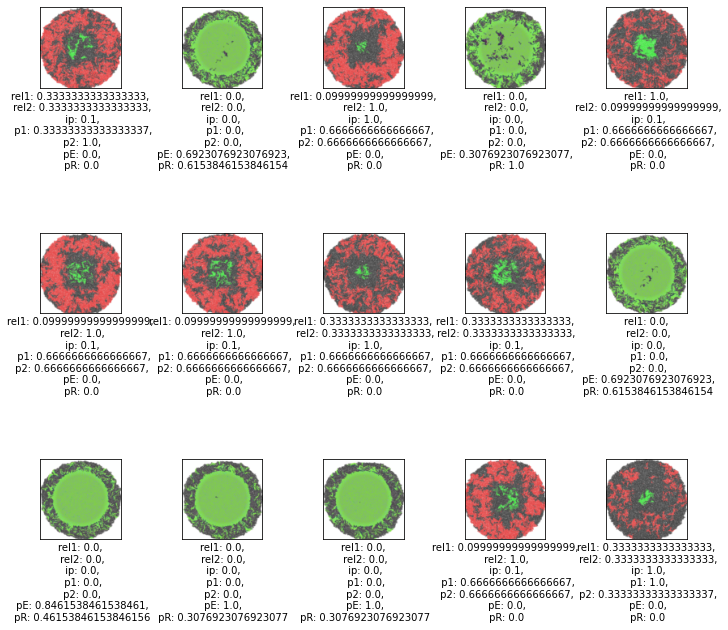

In [ ]:
### visualize samples ### 
data = GroDataset(file_path,csv_path,mode="training")
visualize_gt_data(data)

## GroNet

In [ ]:
class AnnGro(pl.LightningModule):
  def __init__(self, learning_rate=0.04, in_dims=(4,3,100,100), c_i=3, hidden_size=32, fc_1=1000, fc_2=100, num_classes=4, num_types=2):
    super().__init__()
    # log hyperparameters to W & B #
    self.save_hyperparameters()
    
    ### Guillermo architecture Layer ###    
    self.learning_rate = learning_rate
    
    # convolution #
    self.conv1 = nn.Conv2d(self.hparams["c_i"], self.hparams["hidden_size"], 5, 2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(self.hparams["hidden_size"], self.hparams["hidden_size"]*2, 5, 2)
    self.dropout = nn.Dropout()
    
    # Fully connected layer #
    self.fc1 = nn.Linear(self.hparams["hidden_size"]*2 * 5 * 5, self.hparams["fc_1"])
    self.fc2 = nn.Linear(self.hparams["fc_1"], self.hparams["fc_2"])
    
    # Fully connected final outputs #
    self.fc_spatial_class = nn.Linear(self.hparams["fc_2"], self.hparams["num_classes"]) # classify all images
    self.fc_spatial_type = nn.Linear(self.hparams["fc_2"], self.hparams["num_types"]) # classify type_patterns
    
    
    ### compute the accuracy for configuration 1 (classify images and pattern type) ###
    self.train_acc_class = torchmetrics.Accuracy()
    self.valid_acc_class = torchmetrics.Accuracy()
    self.test_acc_class = torchmetrics.Accuracy()
    
    
    
  def forward(self, x):
    # input  -> [n, 3, 100, 100]  [batch size, num_channels, width, height]
    x = self.pool(F.relu(self.conv1(x)))  #-> output: n, 32, 93, 93 
    x = self.pool(F.relu(self.conv2(x)))  #-> output: n, 64, 5, 5
    x = x.view(-1, 64 * 5 * 5)            #-> flatten: n, 400 
    x = self.dropout(x)                   # dropout
    x = self.fc1(x)               # -> n, 120
    x = self.fc2(x)               # -> n, 84
    
    #### return classification ####
    output1 = self.fc_spatial_class(x)  # conf 1 -> n, 4 [bullseye, sun, bioreactor, repressilator]
    output2 = self.fc_spatial_type(x)  # conf 1 -> n, 2 [spatial,temporal]
    '''
    return {
        "classes": F.log_softmax(output1, dim=1),        
        "type": F.log_softmax(output2, dim=1),        
    }
    '''
    return F.log_softmax(output1, dim=1)

   
  ### Get the loss on a batch ###
  def loss_classification(self, input_data, ground_truth):
    ## get the predictions ##
    logits = self(input_data) 
    
    ## calculate the Loss "Neighboard Likehood Loss" ##
    loss = F.nll_loss(logits, ground_truth)  
        
    
    
    return logits, loss

  
  def training_step(self, batch, batch_idx):
    xs,ys = batch
    
    logits, loss = self.loss_classification(xs, ys)
    
    # Returns the indices of the maximum values of a tensor across a dimension.
    preds_class = torch.argmax(logits, 1)  
    
    
    # logging metrics we calculated by hand
    self.log('train_global_loss', loss, on_epoch=True)
    
    # Get the Accuracy 
    self.train_acc_class(preds_class, ys)
            
        
    return loss

  def test_step(self, batch, batch_idx):
    xs,ys = batch
    logits, loss = self.loss_classification(xs, ys)
    
    preds_class = torch.argmax(logits, 1)
    
    
    # logging metrics we calculated by hand
    self.log('test_global_loss', loss, on_step=False, on_epoch=True)
    
    self.test_acc_class(preds_class, ys)
        
    
  def validation_step(self, batch, batch_idx):
    xs,ys = batch
    logits, loss = self.loss_classification(xs, ys)
    preds_class = torch.argmax(logits, 1)
    
    # logging metrics we calculated by hand
    self.log('validation_global_loss', loss)    
        
    
    return logits
    
  
  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr= self.learning_rate)

In [ ]:
class Prediction(pl.Callback):
  def __init__(self, val_samples, num_samples=30):  
      super().__init__()
      self.val_imgs, self.val_labels = val_samples
      self.val_imgs = self.val_imgs[:num_samples]
      self.val_labels = self.val_labels[:num_samples]
        
  def on_validation_epoch_end(self, trainer, pl_module):
      
      val_imgs = self.val_imgs.to(device=pl_module.device)

      logits = pl_module(val_imgs)
      
      predictions = torch.argmax(logits, 1)

      trainer.logger.experiment.log({
          "examples": [wandb.Image(x, caption=f"Prediction:{pred}, ground_truth:{y}") 
                          for x, pred, y in zip(val_imgs, predictions, self.val_labels)],
          "global_step": trainer.global_step
          })            
      
      

In [ ]:
### initialize the dataset with pytorch Lightning ###
dataGro = lightData(file_path=file_path,csv_path=csv_path)
dataGro.setup()
samples = next(iter(dataGro.val_dataloader()))

In [ ]:
wandb_logger = WandbLogger(project='demostration_arc_1', job_type='train') #create a logger

In [ ]:
from pytorch_lightning import callbacks
trainer = pl.Trainer(
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=50,   # set the logging frequency
    gpus=-1,                # use all GPUs
    max_epochs=12,           # number of epochs    
    precision=16,          # 16 bit precision
    callbacks=[Prediction(samples)]
    )

In [ ]:
model = AnnGro()

# train the model #
trainer.fit(model,dataGro)

# evaluate the model on a test set
trainer.test(datamodule=dataGro,
             ckpt_path=None)  # uses last-saved model

wandb.finish()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type             | Params
----------------------------------------------------------
0 | conv1                | Conv2d           | 2.4 K 
1 | pool                 | MaxPool2d        | 0     
2 | conv2                | Conv2d           | 51.3 K
3 | dropout              | Dropout          | 0     
4 | fc1                  | Linear           | 1.6 M 
5 | fc2                  | Linear           | 100 K 
6 | train_metric         | MeanSquaredError | 0     
7 | validation_metric    | MeanSquaredError | 0     
8 | test_metric          | MeanSquaredError | 0     
9 | fc_spatial_inference | Linear           | 707   
----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
3.511     Total estimated model params size (MB)
ERROR:wandb.jupyter:Failed to detect t

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./demostration_arc_2/version_None/checkpoints/epoch=11-step=240.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at ./demostration_arc_2/version_None/checkpoints/epoch=11-step=240.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.01532573439180851
        test/loss          0.007662867753420804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
test/accuracy,▁
test/loss,▁
train/accuracy_epoch,█▄▃▃▂▂▂▂▁▁▁▁
train/accuracy_step,█▅▃▁
train/loss_epoch,█▄▃▃▂▂▂▂▁▁▁▁
train/loss_step,█▅▃▁
trainer/global_step,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇████
validation/accuracy,█▇▅▅▄▃▂▂▂▁▁▁
validation/loss,█▇▅▅▄▃▂▂▂▁▁▁
epoch,12
